In [105]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [106]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [107]:
from sklearn.model_selection import train_test_split
train = train.drop_duplicates()
test = test.drop_duplicates()
train = train.drop(columns='id')
ids = test.id
test = test.drop(columns='id')

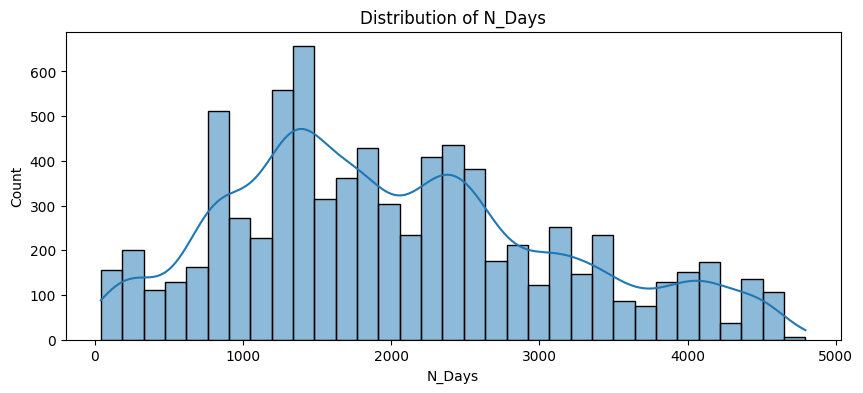

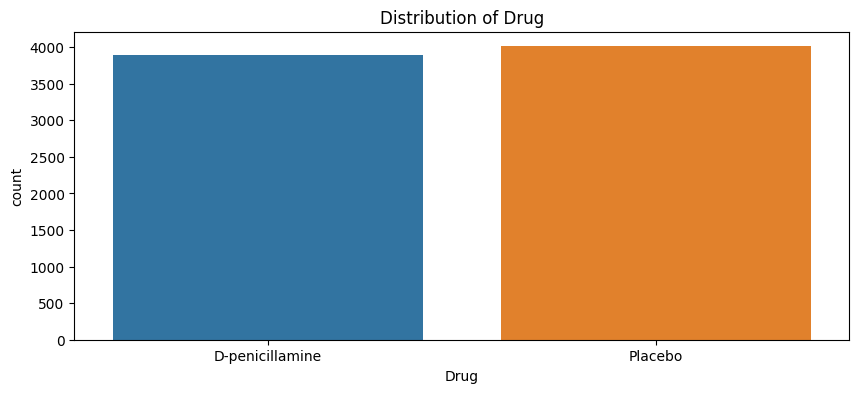

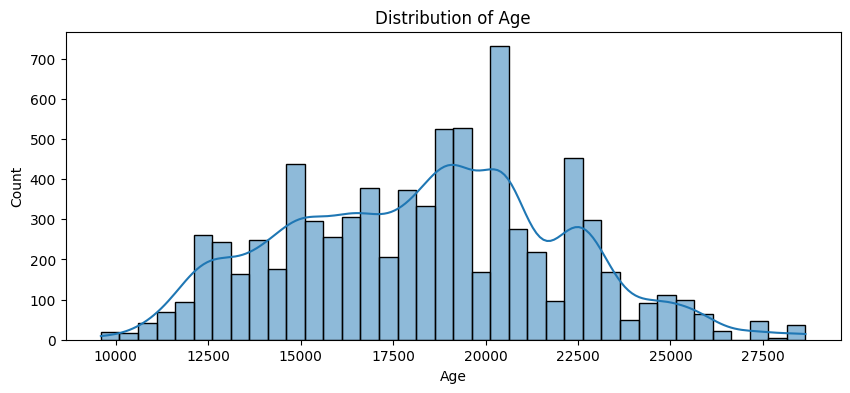

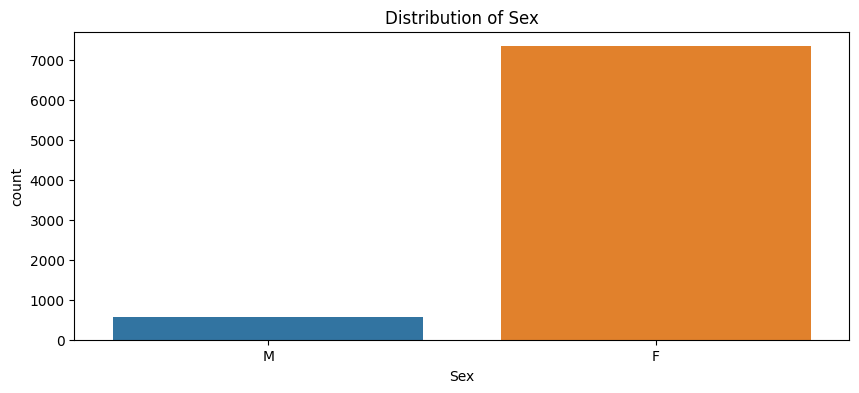

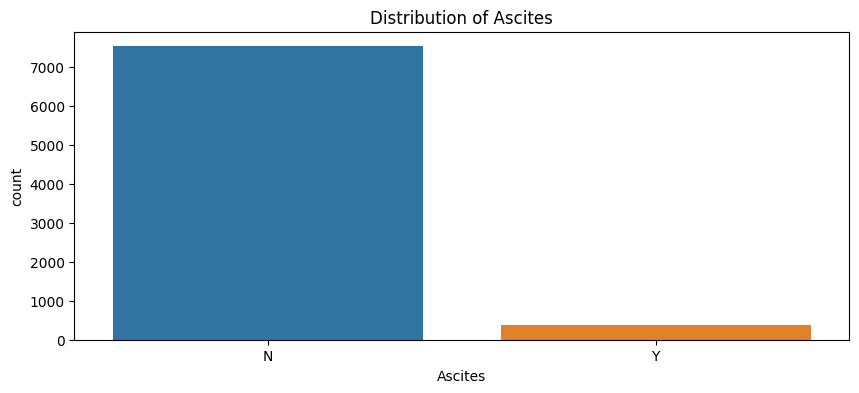

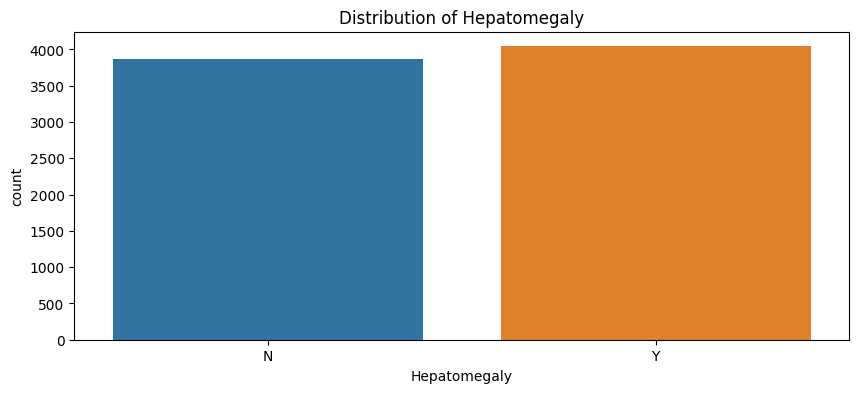

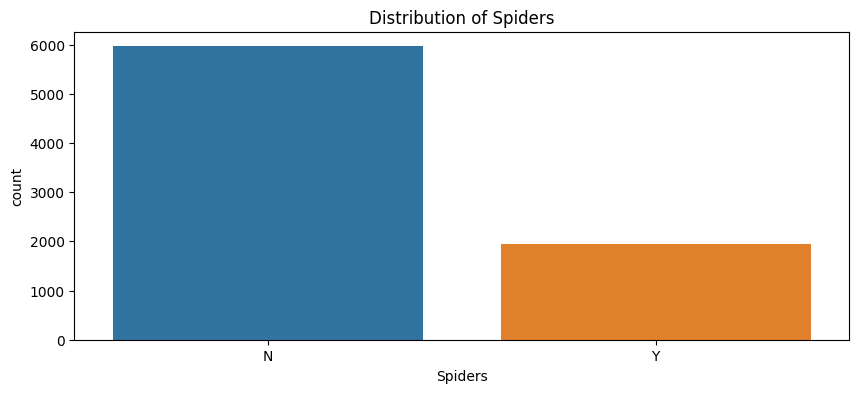

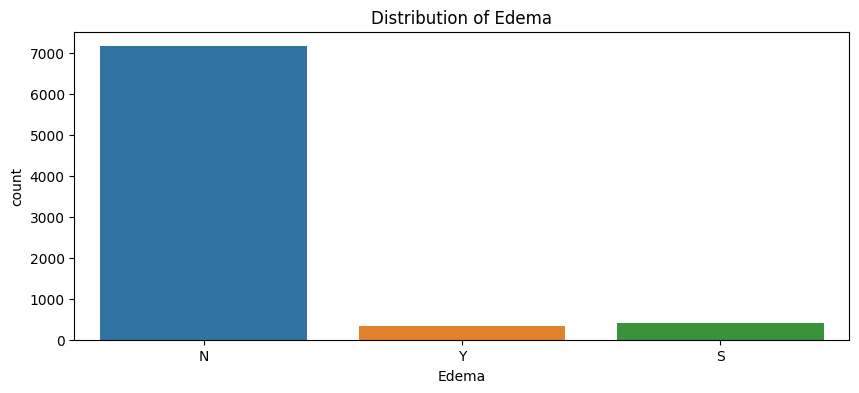

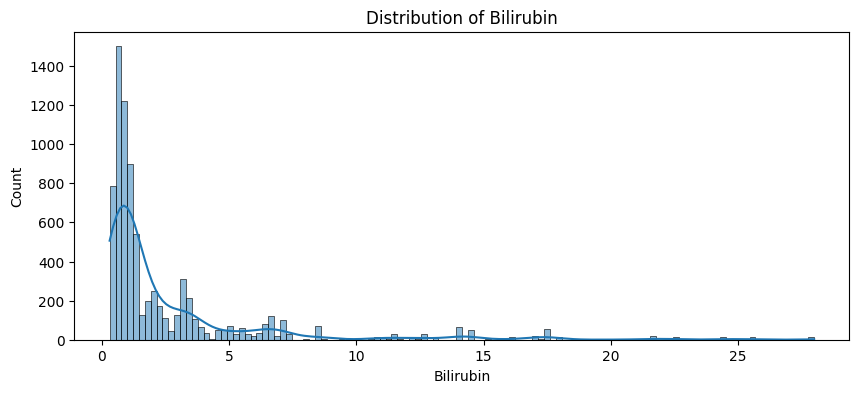

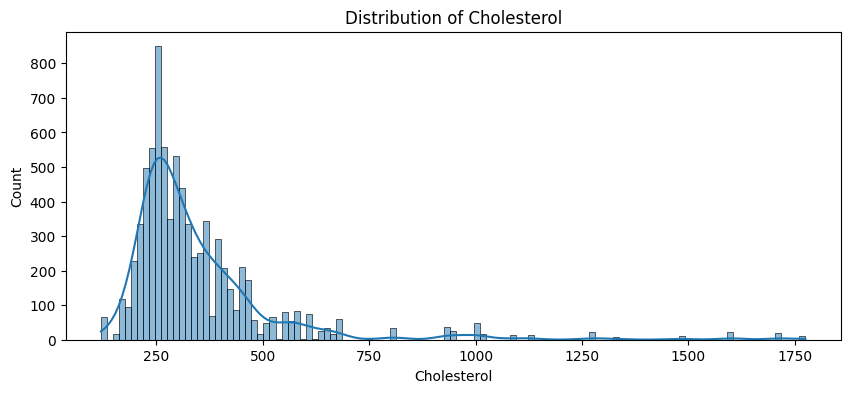

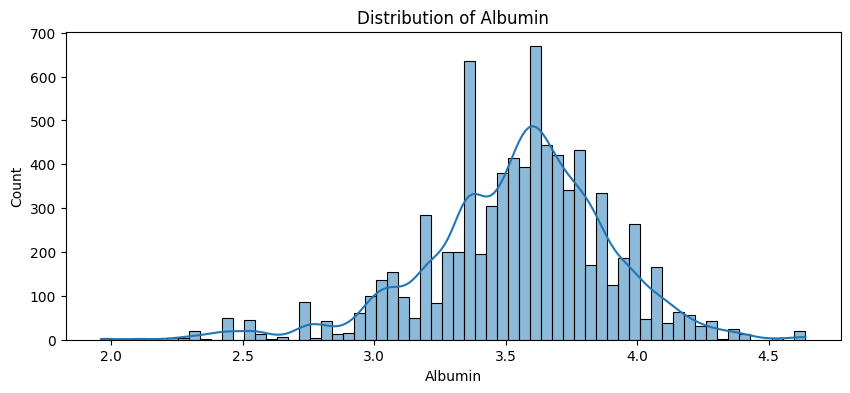

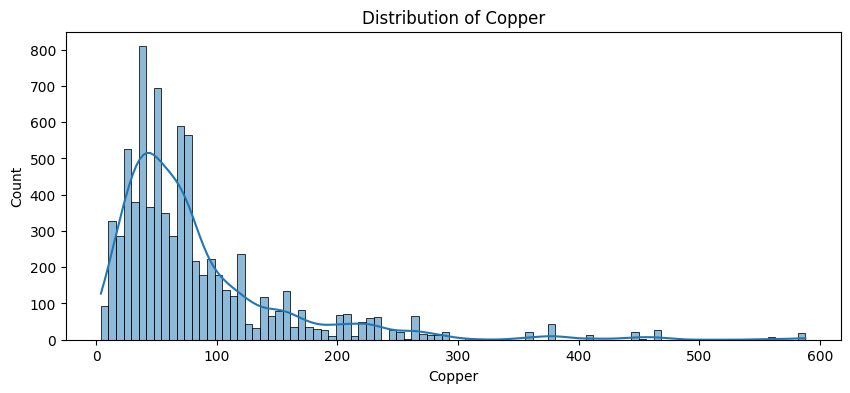

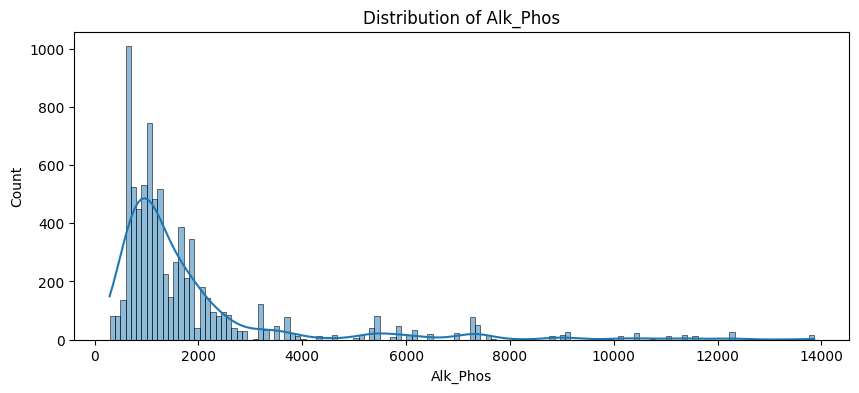

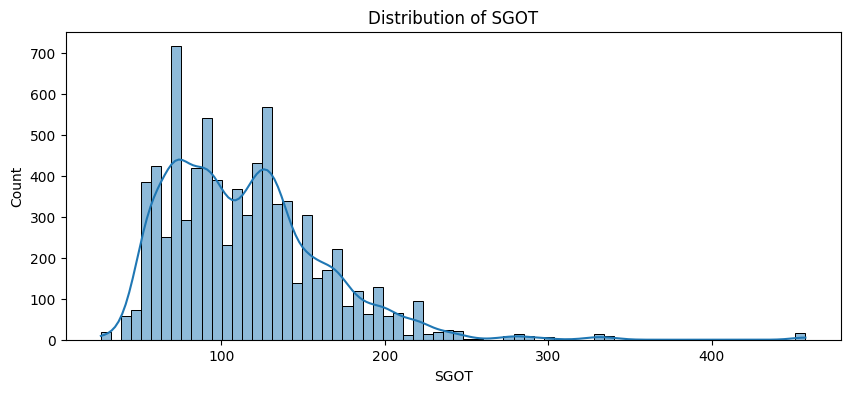

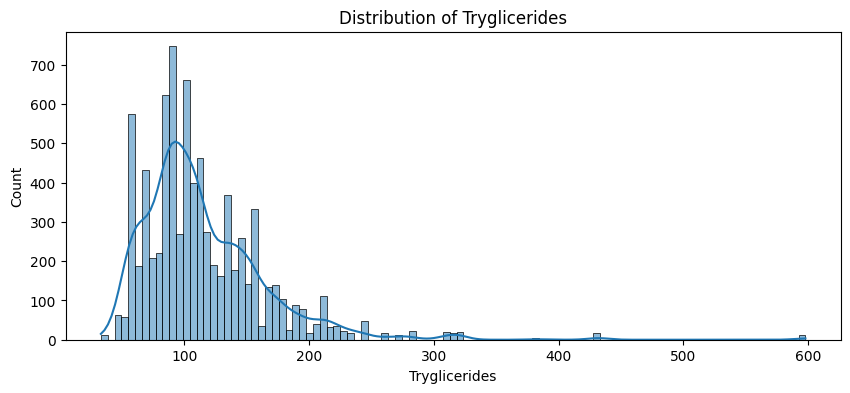

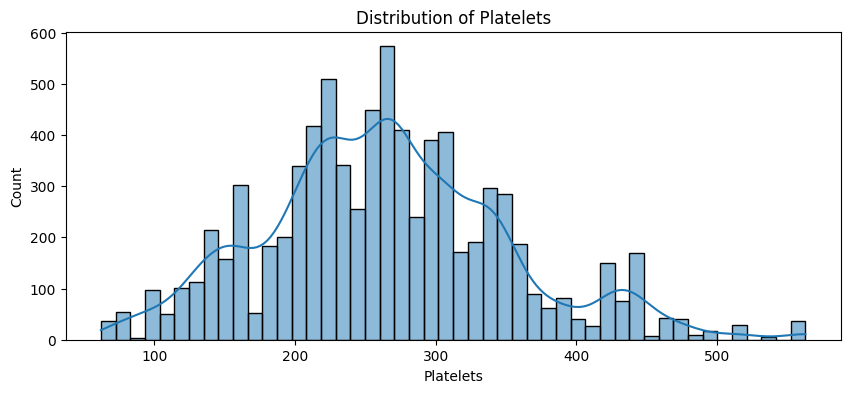

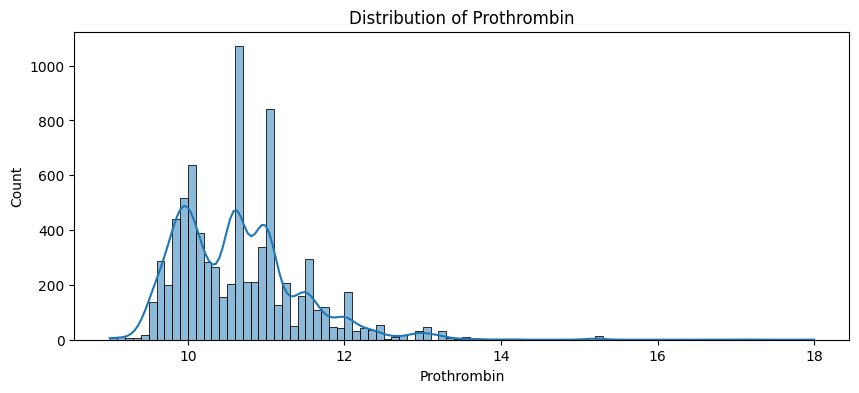

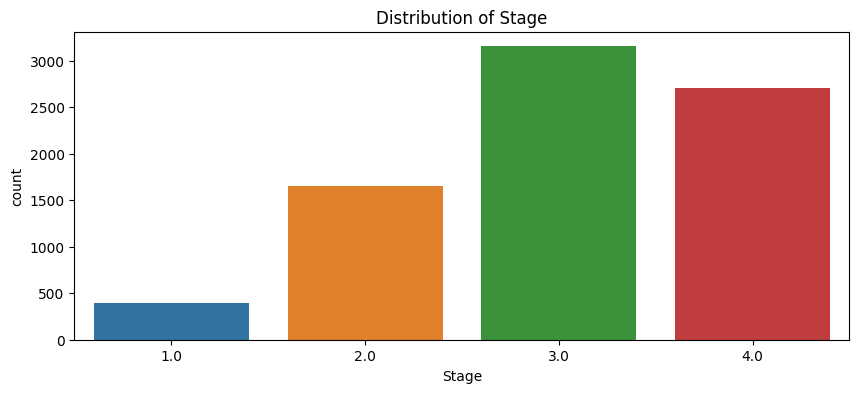

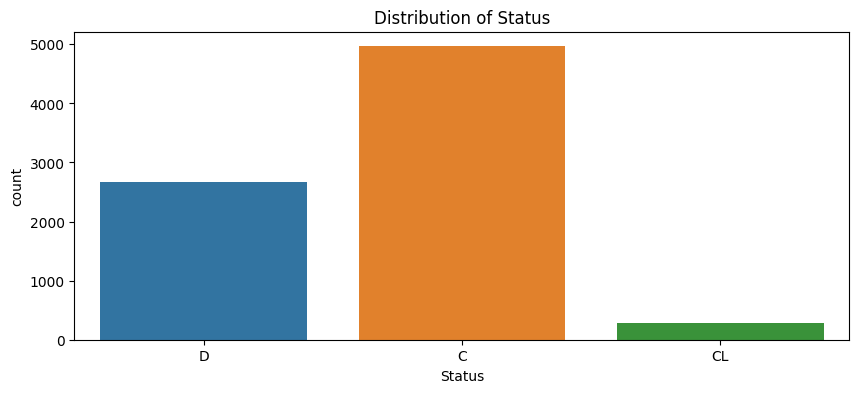

In [108]:
# Checking the distribution of all columns in the dataset
for col in train.columns:
    plt.figure(figsize=(10, 4))
    # Different plotting based on data type
    if train[col].dtype == 'object' or len(train[col].unique()) < 10:
        # For categorical or discrete numerical data
        sns.countplot(x=col, data=train)
    else:
        # For continuous numerical data
        sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

print(cat_features, num_features)

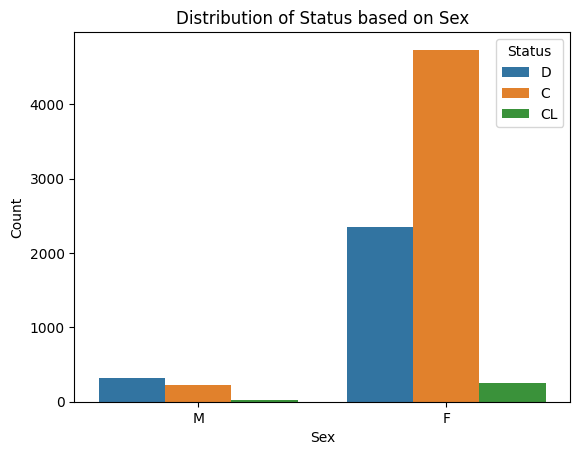

In [109]:
sns.countplot(x='Sex', hue='Status', data=train)
plt.title('Distribution of Status based on Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status  

<Axes: >

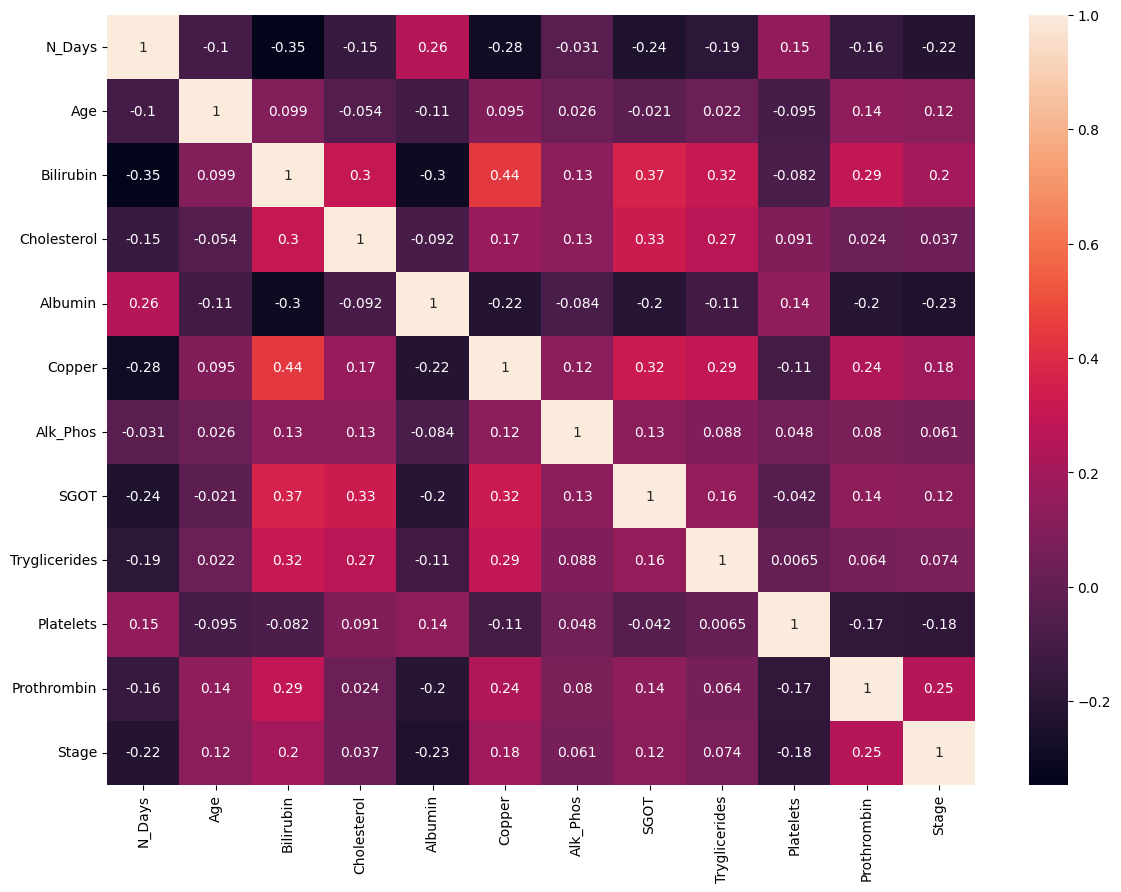

In [111]:
# Let's check out correlations
plt.figure(figsize=(14,10))
sns.heatmap(train.select_dtypes(['int64','float64']).corr(),annot=True)

In [112]:
# Defining groups instead of continuous variables and making squared columns
# Age groups and normal/not normal values

def engineer_features(df):
    numerical_columns = [col for col in train.columns if train[col].dtype in ['int64','float64'] and col != 'id']
    
    bins = [0, 30, 60, 100]  # Define bins for 'Young', 'Middle-aged', and 'Elderly'
    labels = ['Young', 'Middle-aged', 'Elderly']
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    
    df['Bilirubin_Normal'] = ((df['Bilirubin'] < 1.2) & (df['Age'] >= 18)) | ((df['Bilirubin'] < 1) & (df['Age'] < 18))
    df['Cholesterol_Level'] = pd.cut(df['Cholesterol'], bins=[-float('inf'), 200, 239, float('inf')], labels=['0', '1', '2'])
    df['Albumin_Level'] = np.where(df['Albumin'] < 3.4, 1, np.where(df['Albumin'] > 5.4, 2, 0))
    df['Copper_Risk'] = np.where(df['Copper'] > 140, 1, 0)
    df['Alk_Phos_Normal'] = np.where((df['Alk_Phos'] >= 44) & (df['Alk_Phos'] <= 147), 0, 1)
    df['SGOT_Normal'] = np.where((df['SGOT'] >= 8) & (df['SGOT'] <= 45), 0, 1)
    df['Tryglicerides_Level'] = pd.cut(df['Tryglicerides'], bins=[-float('inf'), 150, 199, 499, float('inf')], labels=['0', '1', '2', '3'])
    df['Platelets_Normal'] = np.where((df['Platelets'] >= 150_000) & (df['Platelets'] <= 450_000),0,1)
    df['Prothrombin_Normal'] = np.where((df['Prothrombin'] >= 11) & (df['Prothrombin'] <= 13.5), 0, 1)
    # Polynomial Features
    for col in numerical_columns:
        df[f'{col}_squared'] = df[col] ** 2
        
    return df

train = engineer_features(train)
test = engineer_features(test)

In [113]:
# Do gaussian mixtures 
from sklearn.mixture import GaussianMixture

def  get_gmm_class_features(feat,n):
    gmm=GaussianMixture(n_components=n,random_state=42)
    gmm.fit(train[feat].fillna(train[feat].median()).values.reshape(-1,1))
    train[f'{feat}_class']=gmm.predict(train[feat].fillna(train[feat].median()).values.reshape(-1,1))
    test[f'{feat}_class']=gmm.predict(test[feat].fillna(test[feat].median()).values.reshape(-1,1))
    
get_gmm_class_features('Bilirubin',5)
get_gmm_class_features('Albumin',5)
get_gmm_class_features('SGOT',5)
get_gmm_class_features('Platelets',4)
get_gmm_class_features('Prothrombin',4)
get_gmm_class_features('Stage',4)
get_gmm_class_features('Cholesterol',4)
get_gmm_class_features('Alk_Phos',5)
get_gmm_class_features('Age',5)
get_gmm_class_features('Tryglicerides',4)
get_gmm_class_features('Copper',4)

In [114]:
# Preprocessing

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_features = [col for col in train.columns if train[col].dtype in ['int64','float64']]
cat_features = [col for col in train.columns if train[col].dtype == 'object' and col != 'Status']

num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, num_features),
    ('cat_transformer', cat_transformer, cat_features)
])


X = train.drop(columns=['Status'])
y = train.Status

X = preprocessor.fit_transform(X)
test = preprocessor.fit_transform(test)

# Encoding target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y.values.ravel())

In [115]:
# Hyperparameter tuning
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 0.5),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0.5, 1.0),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.5, 1.0),
        'random_state': 42}

    xgb_classifier = xgb.XGBClassifier(**params)

    skfold = StratifiedKFold(n_splits=3, shuffle=True)
    cv_results = []
    for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        xgb_trained = xgb_classifier.fit(X_train, y_train)
        y_val_pred = xgb_trained.predict_proba(X_val)
        val_log_loss = log_loss(y_val, y_val_pred, )
        cv_results.append(val_log_loss)

    return np.mean(cv_results)

# tuning_study = optuna.create_study(direction="minimize")
# tuning_study.optimize(objective, n_trials=5)

# print("Best trial:")
# best_trial = tuning_study.best_trial
# print(f"  Value: {best_trial.value}")
# print("  Params: ")
# for key, value in best_trial.params.items():
#     print(f"    {key}: {value}")

# best_params = tuning_study.best_params

best_params = {'learning_rate': 0.04472384740629331, 'n_estimators': 769, 'max_depth': 4, 'min_child_weight': 5, 
               'subsample': 0.9891099081740868, 'colsample_bytree': 0.4092754436705531, 'reg_alpha': 0.5325245318617604,
               'reg_lambda': 0.5926863929338334, 'random_state': 42, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss',}
best_xgb = xgb.XGBClassifier(**best_params)

In [116]:
# kfold cross validation

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
n_splits=3
skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    xgb_trained = best_xgb.fit(X_train, y_train)
    y_val_pred = xgb_trained.predict_proba(X_val)
    val_log_loss = log_loss(y_val, y_val_pred)
    cv_results.append(val_log_loss)
    
    print(f'Log loss in fold {fold}: {val_log_loss}')
    
print(f'Overall log loss: {np.mean(cv_results)} +- {np.std(cv_results)}')

    

Log loss in fold 0: 0.45330186913458387
Log loss in fold 1: 0.4424241776931549
Log loss in fold 2: 0.47678852133006516
Overall log loss: 0.4575048560526013 +- 0.014340521902954649


In [117]:
xgb_trained = best_xgb.fit(X, y)
y_test_pred = xgb_trained.predict_proba(test)
submission = pd.DataFrame(y_test_pred)
submission.columns = ['Status_C', 'Status_CL','Status_D'] 
submission['id'] = ids
submission['id'] = submission['id'].apply(lambda x : int(x))
submission.head()
submission.to_csv('submission.csv', index= False)